<a href="https://colab.research.google.com/github/TechWithEva/Telecom-X-Challenge2-G9/blob/main/TELECOM_X_Challenge2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TELECOM X - Churn de Clientes
---
#### ***Problema:***  La empresa enfrenta una alta tasa de cancelaciones y necesita comprender los factores que llevan a la pérdida de clientes.
---



In [ ]:
import pandas as pd
import requests
from numpy._core.defchararray import isnumeric
import matplotlib.pyplot as plt
import seaborn as sns
#

## Integración de Orígenes de Datos

In [ ]:
url = ('https://raw.githubusercontent.com/TechWithEva/Telecom-X-Challenge2-G9/refs/heads/main/rawdata/TelecomX_Data.json')
response=requests.get(url)
data=response.json()
base_ClientesTX = pd.DataFrame(data)
#base_ClientesTX.head()
#

## Tratamiento de Datos

#### Convertir a Archivo Plano y renombrar columnas

In [ ]:
base_ClientesTX = pd.json_normalize(data)
columnasRenombre = {
    'customerID':'clienteID',
    'customer.gender':'genero',
    'customer.SeniorCitizen':'tercera_edad',
    'customer.Partner':'tiene_pareja',
    'customer.Dependents':'tiene_dependientes',
    'customer.tenure':'antiguedadContrato_Meses',
    'phone.PhoneService':'telefono_suscripcion',
    'phone.MultipleLines':'telefono_lineas_multiples',
    'internet.InternetService':'internet_suscripcion',
    'internet.OnlineSecurity':'seguridadOnline_suscripcion',
    'internet.OnlineBackup':'backupOnline_suscripcion',
    'internet.DeviceProtection':'proteccionDispositivos_suscripcion',
    'internet.TechSupport':'soporteTecnico_suscripcion',
    'internet.StreamingTV':'tvDigital_suscripcion',
    'internet.StreamingMovies':'peliculasDigitales_suscripcion',
    'account.Contract':'tipo_contrato',
    'account.PaperlessBilling':'factura_digital',
    'account.PaymentMethod':'metodo_pago',
    'account.Charges.Monthly':'cargos_mensuales',
    'account.Charges.Total':'cargos_totales',
    'Churn':'churn'
    }
base_ClientesTX.rename(columns=columnasRenombre, inplace=True)

base_ClientesTX['pago_automatico']=base_ClientesTX['metodo_pago'].str.contains('automatic').astype(bool)
base_ClientesTX['tipo_servicio_internet']=base_ClientesTX['internet_suscripcion'].apply(lambda x: 'No Internet Service' if x=='No' else x)
base_ClientesTX['internet_suscripcion']=base_ClientesTX['internet_suscripcion'].apply(lambda x: False if x=='No' else True).astype(bool)
#

#### Tratamiento Datos No Esperados y Tipado

In [ ]:
mapeoValoresStr = {
   'Female':'F',
   'Male':'M',
   'Mailed check':'Cheque Postal',
   'Electronic check':'Cheque Electronico',
   'Bank transfer (automatic)':'Transferencia Bancaria',
   'Credit card (automatic)':'Tarjeta Credito',
   'Month-to-month':'mensual',
   'One year':'anual',
   'Two year':'bienal',
   'Fiber optic':'Fibra Optica',
   'DSL':'DSL',
   'No Internet Service':'Sin suscripción a Internet',
   'Yes':True,
   'No':False,
   'No internet service':False,
   'No phone service':False
}
for col in base_ClientesTX.columns:
  if base_ClientesTX[col].dtype == 'object':
    if base_ClientesTX[col].unique()[0] in mapeoValoresStr:
      if base_ClientesTX[col].unique()[0] in ['Yes','No']:
        base_ClientesTX[col]= base_ClientesTX[col].map(mapeoValoresStr).astype(bool)
      else:
        base_ClientesTX[col] = base_ClientesTX[col].map(mapeoValoresStr).astype(str).str.strip().str.upper()

base_ClientesTX['tercera_edad']=base_ClientesTX['tercera_edad'].astype(bool)

base_ClientesTX['cargos_totales'] = pd.to_numeric(
    base_ClientesTX['cargos_totales'].str.strip().str.replace(',', '').replace(' ', ''),
    errors='coerce'
).fillna(0).astype(float)

base_ClientesTX['cargos_diarios'] = base_ClientesTX['cargos_mensuales'] / 30
base_ClientesTX['ambasSuscripciones'] = base_ClientesTX['telefono_suscripcion'] & base_ClientesTX['internet_suscripcion']
#

In [ ]:
#Observar que hay en cada columna
for col in base_ClientesTX.columns:
  print('--------------------------------------------------')
  print(f'Valores únicos de {col.upper()} {base_ClientesTX[col].dtype} : {base_ClientesTX[col].nunique()}')
  print(f'{col}: {base_ClientesTX[col].unique()}')

print('--------------------------------------------------')
print(f'Longitud del código del cliente: {len(base_ClientesTX['clienteID'][0])} máscara "d4-c5"')
print('--------------------------------------------------')
#

#### Tratamiento Duplicados - Nulos - Valores Faltantes - Vacíos

In [ ]:
print(f'Cantidad de duplicados: {base_ClientesTX.duplicated().sum()}')
print(f'Cantidad de nulos: {base_ClientesTX.isnull().sum().sum()}')
print(f'Cantidad de vacíos: {base_ClientesTX.isna().sum().sum()}')
#print(f'Cantidad de Vacíos: {base_ClientesTX.apply(lambda x: x.astype(str).str.strip()=='').sum()}')

base_ClientesTX = base_ClientesTX[base_ClientesTX['churn']!='']
base_ClientesTX = base_ClientesTX[~base_ClientesTX['cargos_totales'].astype(str).str.isspace()]
print(f'Cantidad de Vacíos: {base_ClientesTX.apply(lambda x: x.astype(str).str.strip()=='').sum()}')
#base_ClientesTX.info()

In [ ]:
base_ClientesTX.sample(50)

## Análisis de Datos

### Vista Resumen

In [ ]:
base_ClientesTX.describe(include='all').T

### Distribución de la tasa de abandono segmentado por Antiguedad del Cliente

In [ ]:
bins = [-1, 3, 6, 9, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72]
labels = ['0-3 meses', '4-6 meses', '7-9 meses', '10-12 meses', '13-18 meses', '19-24 meses', '25-30 meses', '31-36 meses', '37-42 meses', '43-48 meses', '49-54 meses', '55-60 meses', '61-66 meses', '67-72 meses']

base_ClientesTX['antiguedad_trimestre'] = pd.cut(base_ClientesTX['antiguedadContrato_Meses'], bins=bins, labels=labels, right=True, include_lowest=True)

churn_rate_by_quarter = base_ClientesTX.groupby('antiguedad_trimestre', observed=False)['churn'].agg(tasa_abandono='mean', total_clientes_rank='count').reset_index()
churn_rate_by_quarter['clientes_abandonaron'] = (churn_rate_by_quarter['tasa_abandono'] * churn_rate_by_quarter['total_clientes_rank']).round().astype(int)

plt.figure(figsize=(14, 7))
fig, ax1 = plt.subplots(figsize=(14, 7))

# Bar plot for total_clientes_rank on primary y-axis
sns.barplot(x='antiguedad_trimestre', y='total_clientes_rank', data=churn_rate_by_quarter, hue='antiguedad_trimestre', palette='viridis', legend=False, ax=ax1)
ax1.set_title('Total Clientes y Clientes que Abandonaron por Trimestre de Antigüedad del Contrato') # Updated title
ax1.set_xlabel('Trimestre de Antigüedad')
ax1.set_ylabel('Total Clientes en Segmento', color='blue') # Updated ylabel
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(range(len(labels)))
ax1.set_xticklabels(labels, rotation=45, ha='right')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Add total_clientes_rank labels on top of the bars
for index, row in churn_rate_by_quarter.iterrows():
    ax1.text(index, row.total_clientes_rank, f'{row.total_clientes_rank}', color='black', ha="center", va='bottom')

# Create a secondary y-axis for clientes_abandonaron
ax2 = ax1.twinx()
ax2.plot(churn_rate_by_quarter['antiguedad_trimestre'], churn_rate_by_quarter['clientes_abandonaron'], color='red', marker='o', linestyle='-', linewidth=2, label='Clientes que Abandonaron') # Updated y and label
ax2.set_ylabel('Clientes que Abandonaron', color='red') # Updated ylabel
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')

# Set the y-limits of ax2 to match ax1 for scale alignment
ax2.set_ylim(ax1.get_ylim())

# Add labels for clientes_abandonaron on the line plot, including churn rate percentage
for index, row in churn_rate_by_quarter.iterrows():
    ax2.text(index, row.clientes_abandonaron, f'{row.clientes_abandonaron} ({row.tasa_abandono:.1%})', color='red', ha="center", va='bottom')

plt.tight_layout()
plt.show()

print("Tasa de Abandono por Trimestre de Antigüedad:")
display(churn_rate_by_quarter)

El análisis de la tasa de abandono revela lo siguiente:
*   **Alta Tasa de Abandono Inicial [0-3 meses]**: En los primeros 3 meses las tasas de abandono más altas. Específicamente, en el primer trimestre (0-3 meses), la tasa de abandono es del **57.65%**, y en el segundo trimestre (4-6 meses) se mantiene alta en **47.03%**. Esto sugiere que los primeros meses son críticos para la retención de clientes.

*   **Disminución Progresiva**: La tasa de abandono disminuye de manera constante a medida que aumenta la antigüedad del cliente. Por ejemplo, para clientes con 19-24 meses, la tasa es del 26.13%, y para aquellos con 37-42 meses, baja a 23.71%.

*   **Baja Tasa de Abandono a Largo Plazo**: Los clientes con una antigüedad superior a los 5 años (61-66 meses) presentan tasas de abandono significativamente más bajas, llegando a un **8.40%** para el grupo de 67-72 meses. Esto indica que los clientes que logran superar los primeros años de servicio son considerablemente más leales.



### Deteccción de Patrones en variable demográficas (Genéro, Tercera Edad, Nucleos Familiares)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
base_Clientes_12Meses_o_Menos = base_ClientesTX[base_ClientesTX['antiguedadContrato_Meses'] <= 12].copy()
categorical_columns = ['genero', 'tercera_edad', 'tiene_pareja', 'tiene_dependientes', 'tipo_contrato']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 18))
axes = axes.flatten()

for i, col in enumerate(categorical_columns):
    ax = axes[i]

    churn_distribution = base_Clientes_12Meses_o_Menos.groupby([col, 'churn']).size().unstack(fill_value=0)

    churn_distribution.rename(columns={False: 'Permanece', True: 'Abandona'}, inplace=True)
    churn_distribution['Total'] = churn_distribution['Permanece'] + churn_distribution['Abandona']

    churn_distribution['Permanece (%)'] = (churn_distribution['Permanece'] / churn_distribution['Total']) * 100
    churn_distribution['Abandona (%)'] = (churn_distribution['Abandona'] / churn_distribution['Total']) * 100

    churn_distribution[['Permanece (%)', 'Abandona (%)']].plot(kind='bar', stacked=False, colormap='Paired', ax=ax)

    ax.set_title(f'Distribución de Churn por {col.replace('_', ' ').title()} (Primeros 12 Meses)')
    ax.set_xlabel(col.replace('_', ' ').title())
    ax.set_ylabel('Porcentaje de Clientes (%)')
    ax.tick_params(axis='x', rotation=0)
    ax.legend(title='Estado de Churn')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Add numerical labels to stacked bars
    for container in ax.containers:
        for j, rect in enumerate(container):
            height = rect.get_height()
            width = rect.get_width()
            x_pos = rect.get_x() + width / 2
            y_pos = rect.get_y() + height / 2

            # Determine which count to display based on the container (Permanece or Abandona)
            if container.get_label() == 'Permanece (%)':
                count_value = churn_distribution['Permanece'].iloc[j]
                percentage_value = churn_distribution['Permanece (%)'].iloc[j]
            elif container.get_label() == 'Abandona (%)':
                count_value = churn_distribution['Abandona'].iloc[j]
                percentage_value = churn_distribution['Abandona (%)'].iloc[j]
            else:
                continue

            ax.text(x_pos, y_pos, f'{count_value} ({percentage_value:.1f}%)', ha='center', va='center', color='darkblue', fontweight='bold', fontsize=8)


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

print(f'Forma del DataFrame base_Clientes_12Meses_o_Menos: {base_Clientes_12Meses_o_Menos.shape}')

categorical_columns = ['genero', 'tercera_edad', 'tiene_pareja', 'tiene_dependientes', 'tipo_contrato']

for col in categorical_columns:
    print(f"\nAnálisis de Churn por '{col.upper()}':")
    churn_analysis = base_Clientes_12Meses_o_Menos.groupby([col, 'churn']).size().unstack(fill_value=0)
    churn_analysis.rename(columns={False: 'no_churn', True: 'churn'}, inplace=True)
    churn_analysis['total_clientes'] = churn_analysis['no_churn'] + churn_analysis['churn']
    churn_analysis['tasa_abandono'] = (churn_analysis['churn'] / churn_analysis['total_clientes']) * 100
    display(churn_analysis.round(2))
    print("--------------------------------------------------")

Basado en el análisis de las variables demográficas y de contrato para clientes con una antigüedad de 12 meses o menos, se observan los siguientes patrones clave en el churn temprano:

#### Género:
* Las tasas de abandono entre hombres y mujeres son muy similares (Femenino: 45.39%, Masculino: 47.78%), con una diferencia de apenas 2.39 puntos porcentuales. Esta pequeña variación sugiere que `el género no es un factor significativo ni influyente en la tasa de abandono temprana` para los clientes con contrato mensual y una antigüedad de 12 meses o menos.

#### Influencia de la Tercera Edad:
* La variable `tercera_edad no parece ser un factor altamente significativo` (Los clientes que NO son de la tercera edad tienen una tasa de abandono ligeramente más alta (47.01%) en los primeros 12 meses, en comparación con los clientes de la tercera edad que tienen una tasa de (42.62%).

#### Presencia de Pareja o Dependientes:
* `Los clientes que "NO tienen pareja"` **presentan una tasa de abandono mayor (54.54%)** que aquellos que *"SÍ tienen pareja" (35.25%)*.
* De manera similar, `los clientes que "NO tienen dependientes"` **tienen una tasa de abandono más alta (48.06%)** que aquellos que *"SÍ tienen dependientes" (38.83%)*.
La variable `tiene_pareja o dependientes` es un **factor muy influyente y significativo** en las estrategias de retención que deben desarrollarse.

#### 1. Impacto del Tipo de Contrato:
* El `tipo_contrato "MENSUAL"` presenta una tasa de abandono significativamente más alta (alrededor del 53.09%) en comparación con los contratos "ANUAL" (12.60%) y "BIENAL" (2.86%). por ende es el mayor factor de riesgo temprano.


### Detección de patrones en consumo de servicios para Clientes con tipo de contratos mensuales y períodos de retención de 12 meses o menos que NO tienen dependientes o pareja.

In [ ]:
df_filtrado_mensual_12meses_sin_familia = base_ClientesTX[
    (base_ClientesTX['antiguedadContrato_Meses'] <= 12) &
    (base_ClientesTX['tipo_contrato'] == 'MENSUAL') &
    (base_ClientesTX['tiene_dependientes'] == False) &
    (base_ClientesTX['tiene_pareja'] == False)
].copy()

df_filtrado_mensual_12meses_sin_familia['servicios_streaming'] = (
    df_filtrado_mensual_12meses_sin_familia['tvDigital_suscripcion'].astype(int) +
    df_filtrado_mensual_12meses_sin_familia['peliculasDigitales_suscripcion'].astype(int)
)

df_filtrado_mensual_12meses_sin_familia['servicios_seguridad_proteccion'] = (
    df_filtrado_mensual_12meses_sin_familia['seguridadOnline_suscripcion'].astype(int) +
    df_filtrado_mensual_12meses_sin_familia['backupOnline_suscripcion'].astype(int) +
    df_filtrado_mensual_12meses_sin_familia['proteccionDispositivos_suscripcion'].astype(int)
)

df_abandonan = df_filtrado_mensual_12meses_sin_familia[df_filtrado_mensual_12meses_sin_familia['churn'] == True].copy()
df_no_abandonan = df_filtrado_mensual_12meses_sin_familia[df_filtrado_mensual_12meses_sin_familia['churn'] == False].copy()

df_abandonan['estado_cliente'] = 'Abandonó'
df_no_abandonan['estado_cliente'] = 'Retenido'

df_comparativo_servicios_sin_familia = pd.concat([df_abandonan, df_no_abandonan], ignore_index=True)

In [ ]:
df_comparativo_servicios_sin_familia['telefono_lineas_multiples'] = df_comparativo_servicios_sin_familia['telefono_lineas_multiples'].astype(int)

internet_service_mapping = {
    'FIBRA OPTICA': 'Fibra Óptica',
    'DSL': 'DSL',
    'SIN SUSCRIPCIÓN A INTERNET': 'Sin Internet'
}
df_comparativo_servicios_sin_familia['tipo_servicio_internet'] = df_comparativo_servicios_sin_familia['tipo_servicio_internet'].map(internet_service_mapping)

In [ ]:
service_columns = [
    'soporteTecnico_suscripcion',
    'servicios_streaming',
    'servicios_seguridad_proteccion',
    'ambasSuscripciones',
    'telefono_lineas_multiples'
]

grouping_cols = ['estado_cliente']

# Calculate mean for service columns
grouped_service_means_sin_familia = df_comparativo_servicios_sin_familia.groupby(grouping_cols)[service_columns].mean().reset_index()

# Analyze distribution of 'tipo_servicio_internet'
internet_service_distribution_sin_familia = df_comparativo_servicios_sin_familia.groupby(grouping_cols + ['tipo_servicio_internet']).size().unstack(fill_value=0)
internet_service_distribution_sin_familia = internet_service_distribution_sin_familia.div(internet_service_distribution_sin_familia.sum(axis=1), axis=0)
internet_service_distribution_sin_familia = internet_service_distribution_sin_familia.reset_index()

print("Mean Service Consumption by Segment (without partner/dependents):")
display(grouped_service_means_sin_familia)

print("\nInternet Service Type Distribution by Segment (without partner/dependents):")
display(internet_service_distribution_sin_familia)

In [ ]:
service_columns_to_plot = [
    'soporteTecnico_suscripcion',
    'servicios_streaming',
    'servicios_seguridad_proteccion',
    'ambasSuscripciones',
    'telefono_lineas_multiples'
]

ylabels = [
    'Suscripción a Soporte Técnico (Media)',
    'Número Promedio de Servicios de Streaming',
    'Número Promedio de Servicios de Seguridad/Protección',
    'Ambas Suscripciones (Teléfono e Internet) (Media)',
    'Múltiples Líneas Telefónicas (Media)'
]

# Create a single figure with multiple subplots (3 rows, 2 columns for 5 plots)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 18)) # Adjust figsize as needed
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i, col in enumerate(service_columns_to_plot):
    ax = axes[i] # Get the current subplot axis

    sns.barplot(
        x='estado_cliente',
        y=col,
        hue='estado_cliente',
        data=grouped_service_means_sin_familia,
        palette='Paired',
        ax=ax,
        legend=False
    )
    ax.set_title(f'Consumo Medio de {ylabels[i].replace('(Media)', '').strip()} (Sin Pareja/Dependientes)') # Clean up title
    ax.set_xlabel('Estado del Cliente')
    ax.set_ylabel(ylabels[i])
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

In [ ]:
df_internet_melted_sin_familia = internet_service_distribution_sin_familia.melt(
    id_vars=['estado_cliente'],
    var_name='tipo_servicio_internet',
    value_name='proporcion'
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_internet_melted_sin_familia,
    x='tipo_servicio_internet',
    y='proporcion',
    hue='estado_cliente',
    palette='Paired'
)
plt.title('Distribución del Tipo de Servicio de Internet por Segmento de Cliente (Sin Pareja/Dependientes)')
plt.xlabel('Tipo de Servicio de Internet')
plt.ylabel('Proporción')
plt.legend(title='Estado del Cliente')
plt.tight_layout()
plt.show()

En resumen se observa:
Los clientes que se categorizan como individuales tienden a adquirir paquetes con múltiples servicios que pueden considerarse planes de gama alta. Basan sus preferencias en Programas con servicios de streaming (TV y Películas), ambas plataformas (telefonía [Múltiples Líneas] y datos [Fibra Optica]). A pesar de contratar estos servicios se observa que consideran el soporte técnico como no prioritario. Y los clientes con mayores tasas de retención cuentan con este servicio.

### Evaluación de Costos de Servicios para los Clientes objetivo que abandonaron durante el primer año, tienen contrato mensual y están categorizados como individuales

In [ ]:
df_comparativo_servicios_sin_familia['tiene_fibra_optica'] = (
    df_comparativo_servicios_sin_familia['tipo_servicio_internet'] == 'Fibra Óptica'
)
df_comparativo_servicios_sin_familia['servicios_streaming'] = (
    df_comparativo_servicios_sin_familia['servicios_streaming'] > 0
)

print("Column 'tiene_fibra_optica' and updated 'servicios_streaming' created successfully.")


In [ ]:
service_features_for_cost_analysis = [
    'soporteTecnico_suscripcion',
    'servicios_streaming',
    'tiene_fibra_optica',
    'telefono_lineas_multiples'
]

# Calculate average monthly charges for each service feature, segmented by churn status
monthly_charges_analysis = pd.DataFrame()

for feature in service_features_for_cost_analysis:
    avg_charges = df_comparativo_servicios_sin_familia.groupby(['estado_cliente', feature])['cargos_mensuales'].mean().reset_index()
    avg_charges.rename(columns={'cargos_mensuales': f'avg_cargos_mensuales_{feature}'}, inplace=True)

    if monthly_charges_analysis.empty:
        monthly_charges_analysis = avg_charges
    else:
        # Merge subsequent features. This will create duplicate rows if not handled carefully.
        # Instead of merging, let's store them in a list and display them separately or concatenate.
        # For display, it's better to show individual analysis.
        pass # We will display each analysis separately for clarity

print("Análisis de cargos mensuales por servicio (individual):")

for feature in service_features_for_cost_analysis:
    avg_charges = df_comparativo_servicios_sin_familia.groupby(['estado_cliente', feature])['cargos_mensuales'].mean().reset_index()
    print(f"\nAnálisis para: {feature}")
    display(avg_charges.round(2))


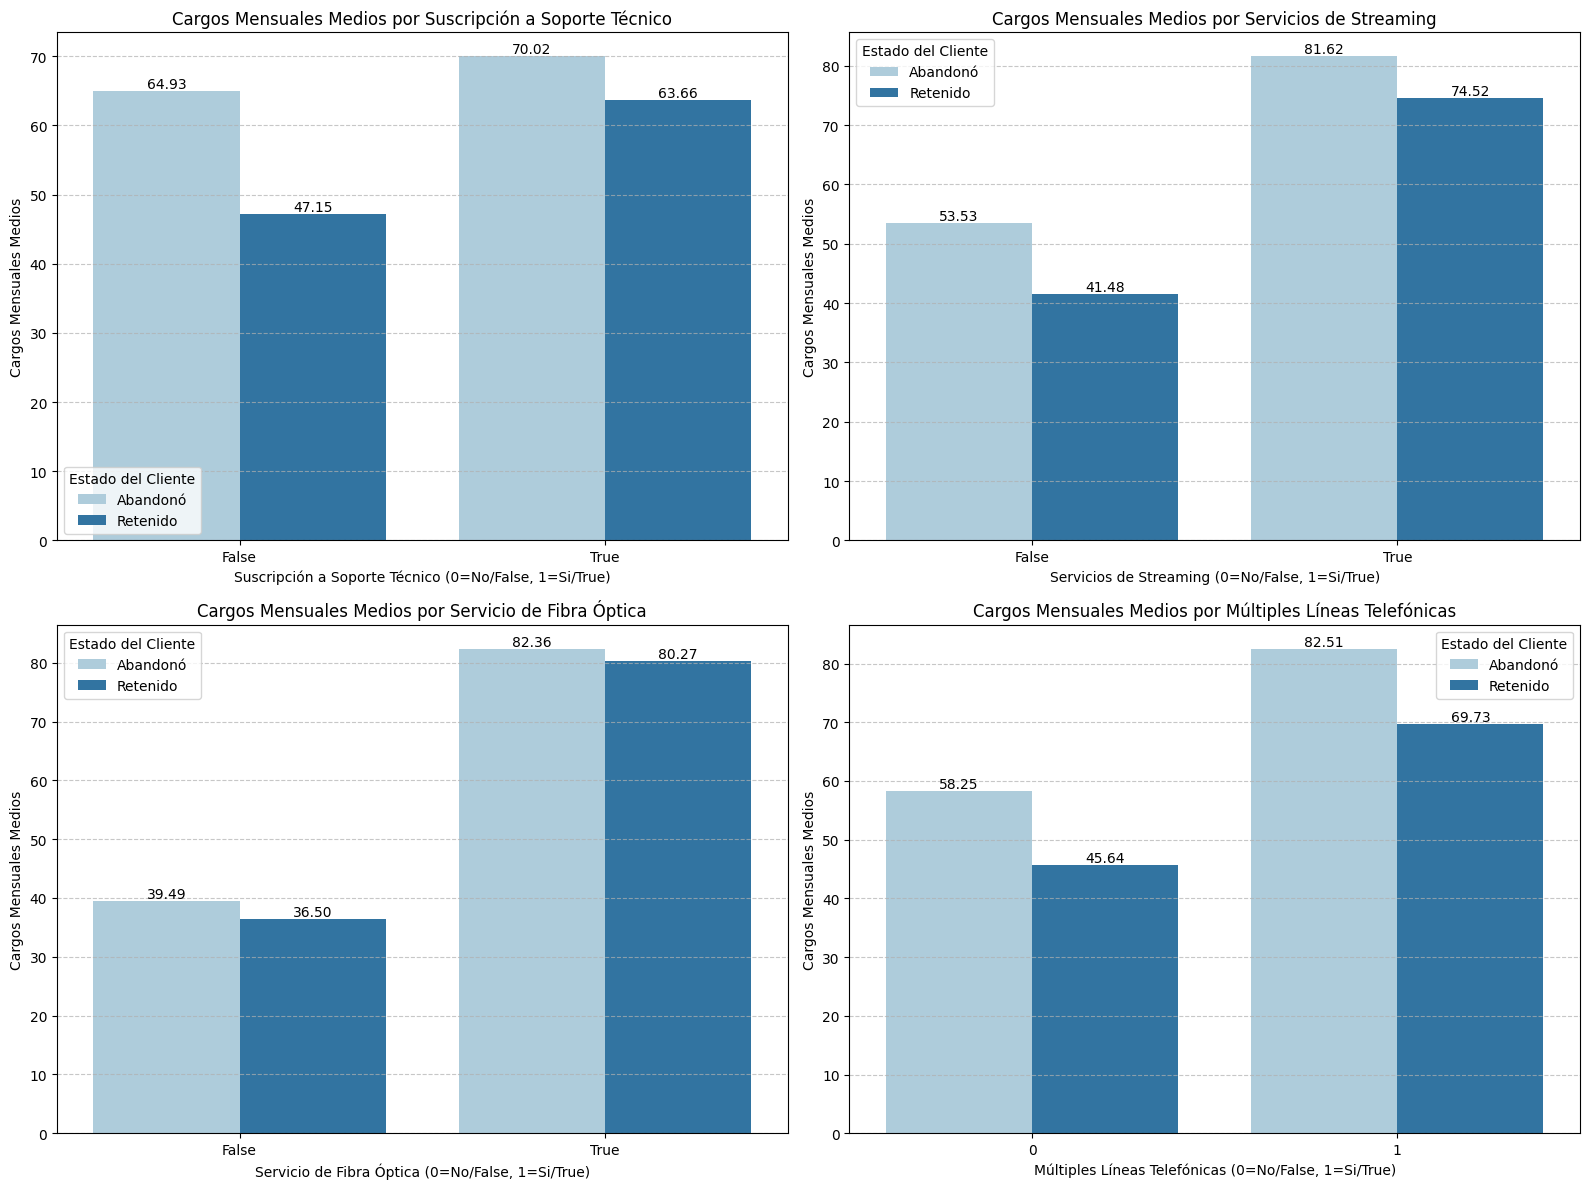

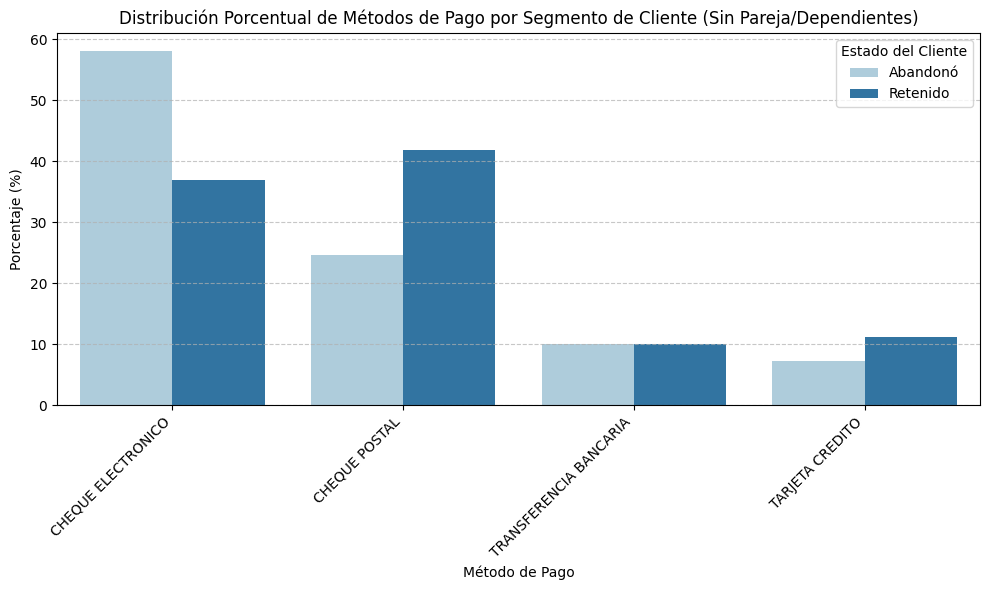

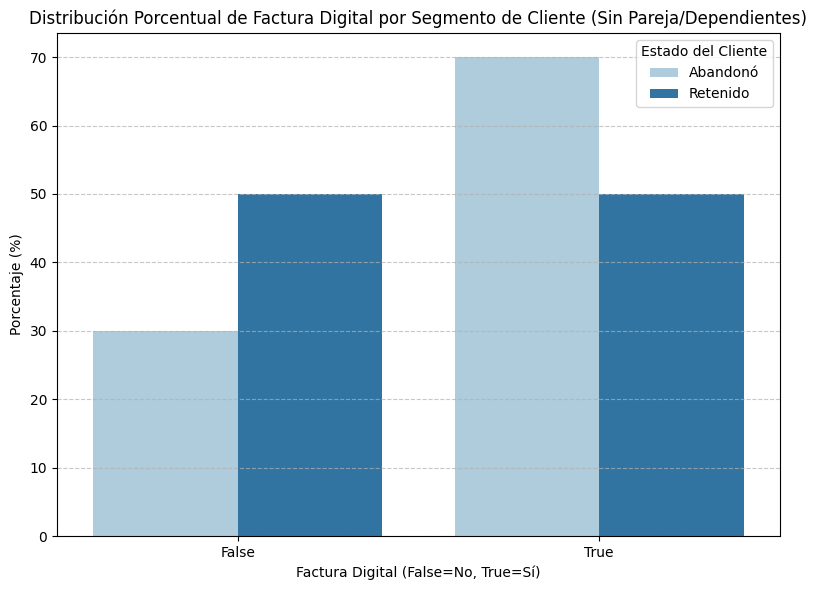

In [143]:
service_features_for_cost_analysis = [
    'soporteTecnico_suscripcion',
    'servicios_streaming',
    'tiene_fibra_optica',
    'telefono_lineas_multiples'
]

ylabels_cost = [
    'Suscripción a Soporte Técnico',
    'Servicios de Streaming',
    'Servicio de Fibra Óptica',
    'Múltiples Líneas Telefónicas'
]

# Create a single figure with multiple subplots for cost analysis
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
axes = axes.flatten()

for i, feature in enumerate(service_features_for_cost_analysis):
    ax = axes[i]
    avg_charges = df_comparativo_servicios_sin_familia.groupby(['estado_cliente', feature])['cargos_mensuales'].mean().reset_index()

    sns.barplot(
        x=feature,
        y='cargos_mensuales',
        hue='estado_cliente',
        data=avg_charges,
        palette='Paired',
        ax=ax
    )
    ax.set_title(f'Cargos Mensuales Medios por {ylabels_cost[i]}')
    ax.set_xlabel(ylabels_cost[i] + ' (0=No/False, 1=Si/True)')
    ax.set_ylabel('Cargos Mensuales Medios')
    ax.legend(title='Estado del Cliente')
    ax.tick_params(axis='x', rotation=0)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Add numerical labels on top of the bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f')

plt.tight_layout()
plt.show()


# New visualization for payment methods
plt.figure(figsize=(10, 6))
# Calculate proportions of each payment method by churn status
payment_method_distribution = df_comparativo_servicios_sin_familia.groupby('estado_cliente')['metodo_pago'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()

sns.barplot(
    x='metodo_pago',
    y='percentage',
    hue='estado_cliente',
    data=payment_method_distribution,
    palette='Paired'
)
plt.title('Distribución Porcentual de Métodos de Pago por Segmento de Cliente (Sin Pareja/Dependientes)')
plt.xlabel('Método de Pago')
plt.ylabel('Porcentaje (%)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Estado del Cliente')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# New visualization for factura_digital
plt.figure(figsize=(8, 6))
# Calculate proportions of factura_digital by churn status
factura_digital_distribution = df_comparativo_servicios_sin_familia.groupby('estado_cliente')['factura_digital'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()

sns.barplot(
    x='factura_digital',
    y='percentage',
    hue='estado_cliente',
    data=factura_digital_distribution,
    palette='Paired'
)
plt.title('Distribución Porcentual de Factura Digital por Segmento de Cliente (Sin Pareja/Dependientes)')
plt.xlabel('Factura Digital (False=No, True=Sí)')
plt.ylabel('Porcentaje (%)')
plt.xticks(rotation=0)
plt.legend(title='Estado del Cliente')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Evaluando la distribución de costos se observa:
1. Soporte Técnico:
Independientemente si cuentan con el o no, los clientes que abandonaron tenían costos significativamente más altos que los retenidos.

2. Servicios de Streaming:
La presencia de servicios de streaming eleva sustancialmente los cargos mensuales. Para clientes retenidos, pasa de 41.48 USD/mes (sin streaming) a 74.52 USD/mes (con streaming). Para los que abandonan, de 53.53 USD/mes a 81.62 USD/mes. Nuevamente se observa que los clientes que abandonaron pagan más por los mismos servicios.

3. Servicios de Internet por Fibra Óptica:
Se refuerza el tema de altos costos. La presencia de servicios de streaming eleva sustancialmente los cargos mensuales. Para clientes retenidos, pasa de 41.48 USD/mes (sin streaming) a 74.52 USD/mes (con streaming). Para los que abandonan, de 53.53 USD/mes a 81.62 USD/mes.

4. Múltiples Líneas Telefónicas:
Aumento de Cargos: Tener múltiples líneas telefónicas incrementa los cargos mensuales. Para clientes retenidos, sube de 45.64 USD/mes (una línea) a 69.73 USD/mes (múltiples líneas). Para los que abandonan, de 58.25 USD/mes a 82.51 USD/mes. Al igual que con los otros servicios, los clientes que abandonan con múltiples líneas pagan más que los retenidos con múltiples líneas.


## Informe de Hallazgos

### Contexto
---
La empresa Telecom X enfrentaba una alta tasa de abandono de clientes y necesitaba comprender los factores subyacentes que llevaban a los usuarios a cancelar sus servicios. Este análisis se llevó a cabo con el objetivo de identificar patrones críticos y razones del abandono de clientes, con un enfoque particular en los clientes en etapas tempranas (primeros 12 meses de contrato) y en segmentos demográficos específicos. Al examinar las tasas de abandono según la antigüedad del contrato, los perfiles demográficos (género, edad de tercera edad, estado civil y dependientes) y los comportamientos de consumo y costo de los servicios, el análisis proporcionó información valiosa para identificar segmentos de clientes en riesgo y desarrollar estrategias de retención dirigidas y efectivas.

### Limpieza y Tratamiento de Datos
---
Proceso:
1. Integrar los datos mediante un request a la url del origen de datos (JSON), para luego ser procesada a un archivo plano en un formato estructurado(dataFrame).
2. Se realizó la limpieza de los datos con el objetivo de dar tratamiento a datos faltantes, valores únicos, valores vacíos y eliminación de duplicados e inconsistencias, renombrado de columnas.
3. Se realizó una verificación de estructura del dataframe con el objeto de realizar un tipado correcto de los datos, adicionar columnas auxiliares, estandarización de valores (se tradujeron a español, se convirtieron a mayúsculas, se les dió tratamiento a strings (eliminando valores no esperados), se mapearon aquellas columnas que se consideraban candidatas a ser tipo boolean ya que tenían valores binarios ('Yes'/'No').Finalmente, las columnas numéricas como cargos_totales se convirtieron a tipo float, manejando cadenas vacías u otros valores no numéricos, coercitándolos a NaN y luego rellenándolos con cero.

**Así los datos han quedado listos para realizar análisis y viz.**



Conclusiones e Insights
--------

Los análisis realizados revelan patrones críticos en la tasa de abandono de clientes de Telecom X, especialmente durante los primeros 12 meses de contrato. A continuación, se presenta un resumen de los hallazgos clave:1. Tasa de Abandono por Antigüedad:Susceptibilidad Temprana: La tasa de abandono son drásticamente altas en los primeros meses de servicio (principalmente de 0 a 6 meses), alcanzando un 57.65% en los primeros 3 meses y un 47.03% entre los 4

1. Tasa de Abandono por Antigüedad:
  * Susceptibilidad Temprana: La tasa de abandono son drásticamente altas en los primeros meses de servicio (principalmente de 0 a 6 meses), alcanzando un 57.65% en los primeros 3 meses y un 47.03% entre los 4 y 6 meses. Esto indica que el periodo inicial es el más crítico para la retención.
  * Estabilización a Largo Plazo: La tasa de abandono disminuye progresivamente con la antigüedad, llegando a ser significativamente baja (8.40%) para clientes con más de 5 años. Los clientes que superan el primer año muestran una mayor lealtad.

   ![image.png](https://raw.githubusercontent.com/TechWithEva/Telecom-X-Challenge2-G9/main/ImageTelecomX_Analisis/RateTrimestralChurn.png)

2. Patrones Demográficos en el Churn Temprano (Primeros 12 meses):
  * Impacto de la Conectividad Familiar: Los clientes que no tienen pareja (54.54% de abandono) y los que no tienen dependientes (48.06% de abandono) muestran tasas de churn considerablemente más altas que aquellos con conexiones familiares. Esto sugiere que cuando los contratos no son individuales sino familiares actúan como factores de retención más efectivos.

  ![image.png](https://raw.githubusercontent.com/TechWithEva/Telecom-X-Challenge2-G9/main/ImageTelecomX_Analisis/ChurnIndividuales_familiares.jpg)
  
  * Tipo de Contrato Mensual: El tipo_contrato "MENSUAL" es un factor de riesgo primordial, con una tasa de abandono del 53.09%. En contraste, los contratos anuales y bienales tienen tasas mucho menores (12.60% y 2.86%, respectivamente), indicando que la flexibilidad del contrato mensual contribuye a la facilidad de abandono.

  ![image.png](https://raw.githubusercontent.com/TechWithEva/Telecom-X-Challenge2-G9/main/ImageTelecomX_Analisis/churn_tipo_contrato.jpg)

  * Género y Tercera Edad: Estas variables no mostraron ser factores significativos en el churn temprano.

  ![image.png](https://raw.githubusercontent.com/TechWithEva/Telecom-X-Challenge2-G9/main/ImageTelecomX_Analisis/ChurnGenero_Edad.jpg)

3. Comportamiento de Consumo y Costo de Servicios en Clientes Individuales (Sin Pareja/Dependientes y Contrato Mensual de 12 meses o menos):
  * Desbalance de Costo y Valor: Los clientes individuales que abandonaron el servicio tenían cargos mensuales consistentemente más altos que los clientes retenidos, a pesar de consumir servicios similares. Esto se observa en:
   * Soporte Técnico: Clientes que abandonan sin soporte técnico pagan 64.93 USD/mes vs 47.15 USD/mes para retenidos. Con soporte, abandonan pagan 70.02 USD/mes vs 55.45 USD/mes para retenidos.
   * Servicios de Streaming: Clientes que abandonan con streaming pagan 81.62 USD/mes vs 74.52 USD/mes para retenidos.
   * Fibra Óptica: Clientes que abandonan con Fibra Óptica pagan 78.89 USD/mes vs 68.22 USD/mes para retenidos.
   * Múltiples Líneas Telefónicas: Clientes que abandonan con múltiples líneas pagan 82.51 USD/mes vs 69.73 USD/mes para retenidos.
   * Percepción de Valor: Los clientes que abandonan, a pesar de tener servicios avanzados (Fibra Óptica, múltiples servicios de streaming, múltiples líneas), perciben un menor valor por su dinero, lo que los lleva a abandonar.
  ![image.png](https://raw.githubusercontent.com/TechWithEva/Telecom-X-Challenge2-G9/main/ImageTelecomX_Analisis/distribuci%C3%B3nmediaservicios.png)
  * Métodos de Pago y Factura Digital: Los clientes que abandonaron tienen una mayor tendencia a usar CHEQUE ELECTRONICO y optar por la factura_digital (70.04% vs 50% de retenidos).
  ![image.png](https://raw.githubusercontent.com/TechWithEva/Telecom-X-Challenge2-G9/main/ImageTelecomX_Analisis/metodosPago_y_Facturacion.png)

##Recomendaciones
---
### Estrategias y Plan de Acción Sugerido
---
Basándonos en el análisis de los datos de churn, especialmente en el segmento de clientes con contrato mensual y una antigüedad de 12 meses o menos, se proponen las siguientes estrategias de retención:

#### 1. Programas de Retención Temprana
**Hallazgo Clave: ** La tasa de abandono es significativamente más alta en los primeros 3 a 6 meses para clientes individuales con contratos mensuales (57.65% en 0-3 meses, 47.03% en 4-6 meses).

**`Estrategia:`** *Desarrollar programas de bienvenida y seguimiento intensivos para nuevos clientes, enfocándose en los segmentos de alto riesgo.*

**Plan de Acción Detallado: **
*   **Identificación de Clientes de Alto Riesgo: ** Al momento de la contratación, identificar a los clientes individuales (sin pareja ni dependientes) que eligen contratos mensuales y tienen menos de 12 meses de antigüedad.
*   **Ofertas Personalizadas (0-6 meses):**
    *   **Primer Mes:** Contacto proactivo (email, SMS) ofreciendo una sesión de orientación gratuita sobre el uso de los servicios contratados y beneficios ocultos. Incluir un pequeño descuento en la primera factura o un beneficio de datos/streaming gratuito por un mes.
    *   **Tercer Mes:** Evaluar el uso del servicio. Si el cliente no ha activado servicios clave (ej. soporte técnico), ofrecer una prueba gratuita de 1 mes de este servicio o un descuento en la tarifa mensual si lo activa. Presentar el valor de la estabilidad en los servicios.
    *   **Sexto Mes:** Campañas dirigidas a la transición a contratos anuales o bienales con incentivos claros. Por ejemplo, ofrecer un mes gratis al cambiar a un plan anual o un descuento significativo en la tarifa por 6 meses al optar por un plan bienal.
*   **Comunicación Dirigida:** Mensajes que enfaticen el valor de los servicios elegidos, comparando sus beneficios con los de la competencia y destacando la flexibilidad sin costos ocultos.

#### 2. Transparencia de Costos y Valor Añadido
**Hallazgo Clave:** Los clientes que abandonan, especialmente los de tipo individual y alto consumo, a menudo pagan más por servicios similares en comparación con los retenidos y tienden a no utilizar servicios de soporte técnico.

**`Estrategia:`** *Mejorar la percepción del valor por el dinero y destacar los beneficios de servicios infravalorados como el soporte técnico, especialmente para clientes con altos cargos.*

**Plan de Acción Detallado:**
*   **Auditoría de Facturación:** Implementar un sistema de auditoría mensual para identificar clientes individuales con cargos mensuales elevados que no utilizan servicios de soporte técnico.
*   **Comunicación Proactiva de Valor:**
    *   **Desglose de Facturas:** Rediseñar las facturas para que sean más claras, detallando el costo de cada servicio y mostrando el valor total que el cliente recibe. Incluir un resumen de beneficios de suscripciones (ej. ahorros anuales por paquete).
    *   **Campañas de Conciencia del Soporte Técnico:** Lanzar campañas informativas que expliquen claramente los beneficios del soporte técnico (resolución rápida de problemas, protección de datos, optimización del rendimiento), con testimonios de clientes satisfechos. Ofrecer 'chequeos' de rendimiento gratuitos o 'horas de consulta' para clientes de alto consumo.
    *   **Ofertas Bundle de Valor:** Para clientes con altos cargos y sin soporte técnico, ofrecer un paquete (bundle) que incluya soporte técnico premium a un costo marginal o gratuito por un período, explicando cómo este servicio puede justificar los cargos elevados al garantizar una experiencia sin interrupciones.

#### 3. Incentivos para Contratos a Largo Plazo
**Hallazgo Clave:** Los contratos mensuales tienen una tasa de abandono significativamente mayor (53.09%) en comparación con los anuales (12.60%) y bienales (2.86%).

**`Estrategia:`** *Crear una fuerte motivación para que los clientes transiten de contratos mensuales a contratos anuales o bienales.*

**Plan de Acción Detallado:**
*   **Descuentos Escalados:**
    *   **Contrato Anual:** Ofrecer un descuento del 15-20% sobre el total anual si el cliente cambia de mensual a anual. Esto podría presentarse como “ahorra 2 meses de servicio al año”.
    *   **Contrato Bienal:** Ofrecer un descuento aún mayor, del 25-30% sobre el total bienal, o un beneficio adicional como un dispositivo premium (router, repetidor Wi-Fi) o una mejora de velocidad gratuita por un año.
*   **Beneficios Exclusivos:** Los clientes con contratos a largo plazo recibirán prioridad en el soporte técnico, acceso anticipado a nuevas funciones o servicios, y beneficios en programas de fidelización (puntos, descuentos con socios).
*   **Comunicación de Estabilidad y Previsibilidad:** Destacar la tranquilidad de no tener aumentos de precio mensuales y la simplicidad de una única factura anual o bienal.

#### 4. Monitoreo de Clientes con Altos Cargos
**Hallazgo Clave:** Clientes individuales con altos cargos mensuales que no contratan soporte técnico son un grupo de riesgo. Los clientes que abandonan tienen cargos mensuales y totales significativamente más altos que los retenidos en el mismo segmento.

**`Estrategia:`** *Implementar un sistema de alerta temprana y un programa de intervención proactiva para estos clientes.*

**Plan de Acción Detallado:**
*   **Sistema de Alerta:** Desarrollar un algoritmo que identifique automáticamente a clientes individuales con:
    *   Cargos mensuales > Percentil 75 del segmento.
    *   Antigüedad < 12 meses.
    *   No suscritos a soporte técnico.
    *   Historial reciente de problemas técnicos o quejas (si disponibles).
*   **Intervención Personalizada:**
    *   **Asesoramiento Proactivo:** Un gestor de cuentas asignado contactará a estos clientes para revisar su paquete de servicios, asegurarse de que están obteniendo el máximo valor y ofrecer soluciones personalizadas para optimizar sus costos o mejorar su experiencia (ej. recomendación de servicios de soporte técnico con incentivos).
    *   **Encuestas de Satisfacción Dirigidas:** Realizar encuestas breves y específicas a este segmento para identificar puntos de dolor antes de que decidan abandonar.

#### 5. Optimización de Experiencia Digital
**Hallazgo Clave:** La distribución de métodos de pago y el uso de factura digital difieren entre clientes retenidos y los que abandonan, especialmente en el segmento individual.

**`Estrategia:`** *Mejorar la experiencia digital y la percepción de seguridad/conveniencia de los métodos de pago, especialmente para aquellos que prefieren cheques electrónicos.*

**Plan de Acción Detallado:**
*   **Mejora de la Plataforma de Facturación Digital:**
    *   **Interfaz Intuitiva:** Optimizar la plataforma de facturación en línea para que sea más fácil de usar, con acceso rápido a históricos de facturas, detalles de consumo y opciones de pago.
    *   **Notificaciones Personalizadas:** Implementar notificaciones inteligentes sobre la fecha de pago, consumo anómalo o recomendaciones de ahorro, enviadas a través de la aplicación móvil o email.
*   **Incentivos para Métodos de Pago Automatizados:** Promover la adopción de transferencia bancaria o tarjeta de crédito (automática) con pequeños incentivos (ej. puntos de lealtad, sorteos), destacando la seguridad y comodidad.
*   **Soporte Mejorado para Cheque Electrónico:** Para los clientes que insisten en cheques electrónicos, asegurar que el proceso sea lo más fluido y seguro posible, con soporte al cliente disponible para cualquier incidencia, mitigando posibles frustraciones que puedan llevar al abandono.

Este plan integral busca abordar los puntos críticos de abandono identificados, ofreciendo soluciones específicas y personalizadas para mejorar la retención de clientes de TELECOM X.